In [1]:
# python basic pacakages
import aifc
import os
import datetime
from os import listdir
from os.path import isfile, join
import csv

# required packags
import tensorflow as tf
import numpy as np
import pandas as pd

from matplotlib import mlab
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# my packages
from DataManager.Audio import *
from DataManager.General import *

In [2]:
# labels_path = "C:\\Users\\jorge\\DatasetsTFM\\KaggleData\\train.csv"
# train_path = "C:\\Users\\jorge\\DatasetsTFM\\KaggleData\\train"

labels_path = "data/train.csv"
train_path = "data/train"
redux_train_path = "data/train2"

audiofiles = [os.path.join(train_path, f) for f in listdir(train_path) if isfile(join(train_path, f))]
audiofiles_redux = [os.path.join(redux_train_path, f) 
                    for f in listdir(redux_train_path) if isfile(join(redux_train_path, f))]

limitator = None

In [47]:
np.array([int(clip_name[-5]) for clip_name in audiofiles_redux]).sum()/len(audiofiles_redux)

0.11028197571121005

In [48]:
labels_dict = get_labels(labels_path)

seconds_in_sound = 1.7
p_cut = seconds_in_sound/2
top_hz = 50

# Get a random permutation to remove ordering bias
np.random.shuffle(audiofiles)

# convert the list of files to numpy arrays and select a random smaller version if limitador is not None
X_path = np.array(audiofiles)[:limitator]

# Start the process of data extraction, spectrogram transformation and data enhancement
print('Generating train and test split')
X_train_path, X_test_path = train_test_split(X_path, test_size=0.2)

print('Getting test spectrograms')
X_test, Y_test = get_spects(X_test_path, labels_dict, p=p_cut, top_hz=top_hz)

# print('Getting test spectrograms')
# X_train, Y_train = get_spects(X_train_path, labels_dict)

print('Getting train spectrograms + enhancement')
X_train, Y_train = get_spects_enhanced(X_train_path, labels_dict, p=p_cut, top_hz=top_hz)

print('Getting even more data adding noise to whale calls')
X_enhanced, Y_enhanced = enhance_with_noise(X_train, Y_train)

X_train, Y_train = np.concatenate([X_train, X_enhanced]), np.concatenate([Y_train, Y_enhanced])

print('Test', X_test.shape)

print('Train', X_train.shape)


Generating train and test split
Getting test spectrograms
Getting train spectrograms + enhancement
Getting even more data adding noise to whale calls
Test (6000, 50, 50)
Train (88866, 50, 50)


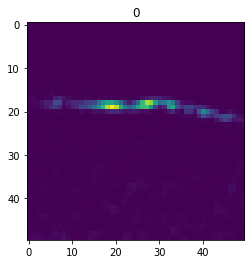

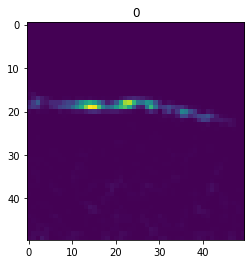

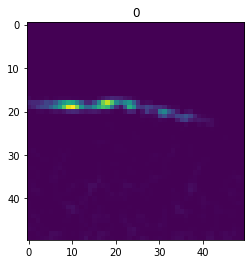

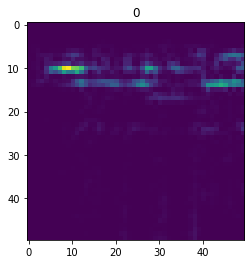

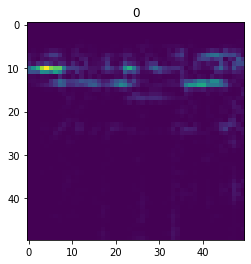

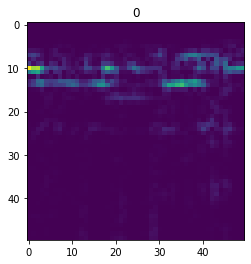

0.027529244340208276


In [5]:
def f(x):
    return x / x.max()
    
for i in range(X_train.shape[0]):
    n_index = i
    X_train_t = np.array(list(map(f, X_train)))
    plt.imshow(X_train_t[n_index])
    plt.title(Y_train[n_index])
    plt.show()
    if i > 4:
        print(X_train_t[n_index].mean())
        break

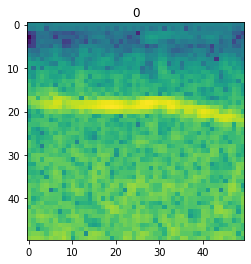

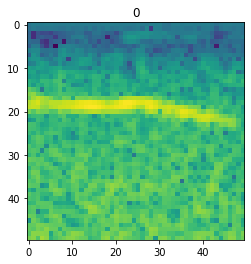

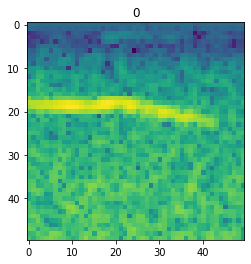

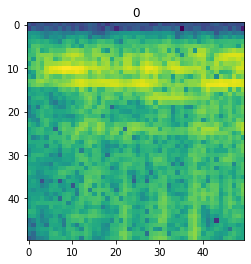

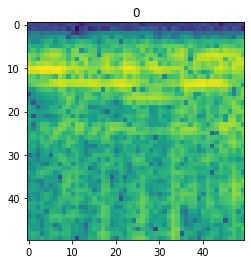

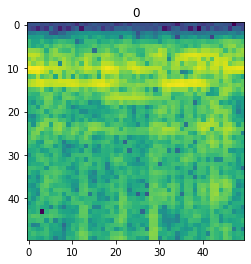

5.343718780749894


In [6]:
def f(x):
    return np.log(x)
    
for i in range(X_train.shape[0]):
    n_index = i
    X_train_t = np.array(list(map(f, X_train)))
    plt.imshow(X_train_t[n_index])
    plt.title(Y_train[n_index])
    plt.show()
    if i > 4:
        print(X_train_t[n_index].mean())
        break


## Normalize small

In [20]:
np.array(list(map(f_norm, X_train)))[0].max(), np.array(list(map(f_norm, X_train)))[0].min()

(18.0679833853324, -0.1535846615185723)

In [49]:

# def imagery(x, new_shape, top_hz):

#     return np.array(Image.fromarray(X_train[0][:top_hz]).convert("L").resize(new_shape))

def f(x):
    return x / x.max()

def log_norm(x):
    log_spect = np.log(x + 1)
    return log_spect / log_spect.max()

def f_05(x):
    x_min = x.min()
    return (x - x_min) / (x.max() - x_min) - .5


def f_norm(x):
    x_min = x.min()
    return (x - x.mean()) / x.std()
    

X_train = np.array(list(map(f_norm, X_train)))  # lambda x: imagery(x, [32,32], 60), X_train)))
X_test = np.array(list(map(f_norm, X_test)))  # lambda x: imagery(x, [32,32], 60), X_test)))


In [50]:
print('Test: Whale %.4f, Not Whale %.4f' % ((Y_test == '1').sum() / Y_test.shape[0], 
                                            (Y_test == '0').sum() / Y_test.shape[0]))

print('Train: Whale %.4f, Not Whale %.4f' % ((Y_train == '1').sum()  / Y_train.shape[0], 
                                             (Y_train == '0').sum()  / Y_train.shape[0]) )

Test: Whale 0.2342, Not Whale 0.7658
Train: Whale 0.3796, Not Whale 0.6204


In [51]:
'Tamaño en memoria de los datos de training aprox: %.2fGB' % (X_train.nbytes/2**10/2**10/2**10)

'Tamaño en memoria de los datos de training aprox: 1.66GB'

In [52]:
Y_train, Y_test = Y_train.astype(int), Y_test.astype(int)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

Y_train, Y_test = tf.keras.utils.to_categorical(Y_train, 2), tf.keras.utils.to_categorical(Y_test, 2) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [53]:
def create_base_network(input_shape, kernel_size=(6,6), final_dimension=12, regularization=0.011):
    # model building
    model = tf.keras.models.Sequencial()
    # convolutional layer with rectified linear unit activation
    # flatten since too many dimensions, we only want a classification output
    model.add(tf.keras.models.Conv2D(1, kernel_size=kernel_size,
                     activation='relu',
                     input_shape=input_shape, kernel_initializer=init,
                bias_initializer='zeros',
                kernel_regularizer=regularizers.l1(regularization),#0.011
                bias_regularizer=regularizers.l1(regularization)))#0.011
    
    model.add(tf.keras.models.Dropout(0.5))
    model.add(tf.keras.models.Conv2D(1, kernel_size=kernel_size,
                    activation='relu', kernel_initializer=init,
                bias_initializer='zeros',
                kernel_regularizer=regularizers.l1(regularization),#0.011
                bias_regularizer=regularizers.l1(regularization)))#0.011
    
    model.add(tf.keras.models.Dropout(0.5))
    # things to test in order to increase the performance of the mdel
    # play a little with the kernel sizes - test values: (6,6)
    # change the optimization function - 
    model.add(tf.keras.models.Flatten())
    # embedding sizes with better results seem to be between [8,15[
    model.add(tf.keras.models.Dense(final_dimension, activation='softmax', kernel_initializer=init,
                bias_initializer='zeros'))#13
    print(model.summary())
    return model


class siamese:
    def __init__(self, input_shape, regularization=0.011, kernel_size=(6,6), final_dimension=12, learning_rate=0.0004, margin=1.2):
        self.base_network = create_base_network(input_shape, kernel_size, final_dimension, regularization)

        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)

        # because we re-use the same instance `base_network`,
        # the weights of the network
        # will be shared across the two branches
        processed_a = self.base_network(input_a)
        processed_b = self.base_network(input_b)

        distance = Lambda(cosine_distance,  # compare this results with euclidean
                          output_shape=cos_dist_output_shape)([processed_a, 
                          processed_b])

        model = Model([input_a, input_b], distance)

        adam = Adam(lr=learning_rate)
        loss_function = contrastive_loss(margin)
        model.compile(loss=loss_function.loss, optimizer=adam, metrics=[accuracy])
        self.model = model

    def save_base_network(self, k):
        (self.base_network).save_weights("./validation_models/base_network_partition_" + str(k) + ".h5")
        
        
class winners:
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(20, kernel_size=(7, 7), activation=tf.nn.relu, 
                                   input_shape=X_train.shape[1:], name='Conv1'),
            tf.keras.layers.Dropout(0.2),  
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(40, kernel_size=(7, 7), activation=tf.nn.relu, name='Conv2'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation=tf.nn.relu, name="Dense1"),
            tf.keras.layers.Dropout(0.6),
            tf.keras.layers.Dense(2, activation=tf.nn.softmax, name="Softmax")
            ])
    
class winners_regression:
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(20, kernel_size=(7, 7), activation=tf.nn.relu, 
                                   input_shape=X_train.shape[1:], name='Conv1'),
            tf.keras.layers.Dropout(0.2),  
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(40, kernel_size=(7, 7), activation=tf.nn.relu, name='Conv2'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation=tf.nn.relu, name="Dense1"),
            tf.keras.layers.Dropout(0.6),
            tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, name="Regression")
            ])
    
class bigger:
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(7, 7), activation='relu', input_shape=X_train.shape[1:]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
class cnn32:
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(7, 7), activation='relu', input_shape=X_train.shape[1:]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(2, activation='softmax'))


In [ ]:
model = winners

opt = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# opt = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.model.compile(optimizer=opt,
                    loss='binary_crossentropy', # loss for classification
#                     loss='mse',  # loss for classification
                    metrics=['accuracy'])


print('Training model')
history = model.model.fit(X_train, Y_train, epochs=60, verbose=2, validation_split=0.2)
score = model.model.evaluate(X_test, Y_test)


Training model
Train on 71092 samples, validate on 17774 samples
Epoch 1/60
 - 189s - loss: 7.0597 - acc: 0.5527 - val_loss: 0.6376 - val_acc: 0.9602
Epoch 2/60
 - 191s - loss: 7.0720 - acc: 0.5547 - val_loss: 0.6376 - val_acc: 0.9602
Epoch 3/60
 - 173s - loss: 7.1222 - acc: 0.5518 - val_loss: 0.6376 - val_acc: 0.9602
Epoch 4/60
 - 180s - loss: 7.1594 - acc: 0.5501 - val_loss: 0.6376 - val_acc: 0.9602
Epoch 5/60
 - 180s - loss: 7.1543 - acc: 0.5513 - val_loss: 0.6376 - val_acc: 0.9602
Epoch 6/60
 - 167s - loss: 7.1818 - acc: 0.5498 - val_loss: 0.6376 - val_acc: 0.9602
Epoch 7/60
 - 171s - loss: 7.5426 - acc: 0.5274 - val_loss: 0.6376 - val_acc: 0.9602
Epoch 8/60
 - 210s - loss: 9.1616 - acc: 0.4257 - val_loss: 0.6376 - val_acc: 0.9602
Epoch 9/60
 - 192s - loss: 9.1808 - acc: 0.4255 - val_loss: 0.6376 - val_acc: 0.9602
Epoch 10/60
 - 189s - loss: 9.1849 - acc: 0.4252 - val_loss: 0.6376 - val_acc: 0.9602
Epoch 11/60
 - 204s - loss: 9.1575 - acc: 0.4273 - val_loss: 0.6376 - val_acc: 0.960

In [ ]:
score

In [ ]:
print(score)
print('Finished at {}, saving the results as graphs.'.format(datetime.datetime.now()))

#Accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# plt.savefig(save_path + tag + 'model_accuracy' + str(score[1]) + '.pdf')
plt.show()

#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# plt.savefig(save_path + tag + 'model_loss' + str(score[1]) + '.pdf')
plt.show()

In [15]:
# y_hat

In [ ]:
#Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score
import numpy as np
#Compute probabilities
Y_pred = model.model.predict(X_test)
#Assign most probable label
y = np.argmax(Y_test, axis=1)  # Y_test #
y_hat = np.argmax(Y_pred, axis=1)  # np.round(Y_pred)  #
#Plot statistics
print('Analysis of results')
target_names = ['no_whale', 'whale']
print(classification_report(y, y_hat, target_names=target_names))
print(confusion_matrix(y, y_hat))
print(roc_auc_score(y, y_hat))

y_pred_proba = winners.model.predict_proba(X_test)[::,1]

print('\nROC AUC with probabilities %.4f' % roc_auc_score(y, y_pred_proba))


In [ ]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# y_pred_proba = winners.model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
auc = metrics.roc_auc_score(y, y_pred_proba)
plt.plot(fpr,tpr,label='Winners (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# python basic pacakages
import aifc
import os
import datetime
from os import listdir
from os.path import isfile, join
import csv

# required packags
import tensorflow as tf
import numpy as np
import pandas as pd

from matplotlib import mlab
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# my packages
from DataManager.Audio import *
from DataManager.General import *


def preprocess(files_train, files_test, labels, normalization_function, to_categorical=False):

    x_test, y_test = get_spects(files_test, labels)

    x_train, y_train = get_spects_enhanced(files_train, labels)
    x_enhanced, y_enhanced = enhance_with_noise(x_train, y_train)

    x_train, y_train = np.concatenate([x_train, x_enhanced]), np.concatenate([y_train, y_enhanced])

    y_train, y_train = y_train.astype(int), y_test.astype(int)
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

    y_train, y_test = tf.keras.utils.to_categorical(y_train, 2), tf.keras.utils.to_categorical(y_test, 2)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

    x_train = np.array(list(map(normalization_function, x_train)))
    x_test = np.array(list(map(normalization_function, x_test)))

    y_train, y_test = y_train.astype(int), y_test.astype(int)
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

    if to_categorical:
        y_train, y_test = tf.keras.utils.to_categorical(y_train, 2), tf.keras.utils.to_categorical(y_test, 2)
    else:
        y_train, y_test = y_train.astype(int), y_test.astype(int)

    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

    return x_train, y_train, x_test, y_test


def k_fold_cross_validation(x_files, labels_path, model, f_preprocess, n_splits=5, shuffle=True, seed=None):

    if seed is not None:
        np.random.seed(seed)
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)

    else:
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle)

    cvscores = []
    cvhistories = []

    opt = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    labels_dict = get_labels(labels_path)

    for train, test in kfold.split(x_files,  map(lambda x: labels_dict[x], x_files)):
        x_train, y_train, x_test, y_test = f_preprocess(x_files[train], x_files[test], labels_dict)
        # Compile model
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        history = model.model.fit(x_train, y_train, epochs=150, verbose=2, validation_split=0.2)
        score = model.model.evaluate(x_test, y_test)
        cvhistories.append(history)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))
        cvscores.append(score[1] * 100)


In [86]:
# MLP for Pima Indians Dataset with 10-fold cross validation
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset
dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train in kfold.split(X):
  # create model
	model = Sequential()
	model.add(Dense(12, input_dim=8, activation='relu'))
	model.add(Dense(8, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	# Fit the model
	model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
	# evaluate the model
	scores = model.evaluate(X[test], Y[test], verbose=0)
	print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
	cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

Using TensorFlow backend.


OSError: pima-indians-diabetes.csv not found.

[]

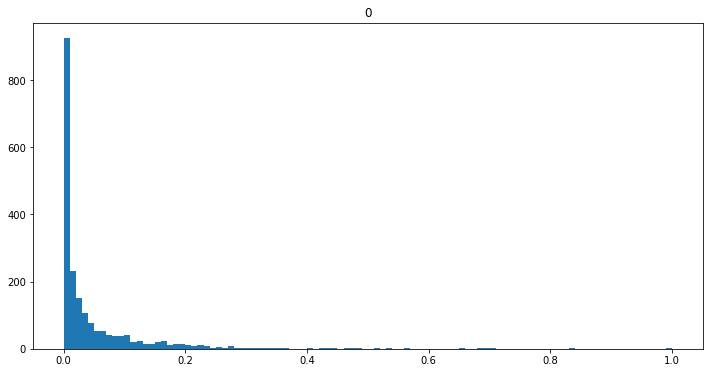

In [13]:
n_s = 4
plt.figure(figsize=(12,6))
plt.title(np.argmax(Y_test[n_s]))
q = plt.hist(X_train[n_s].flatten(), bins=100)
plt.plot()

In [ ]:
Training model
Train on 71059 samples, validate on 17765 samples
Epoch 1/50
71059/71059 [==============================] - 1418s 20ms/sample - loss: 0.2729 - acc: 0.8863 - val_loss: 2.1389 - val_acc: 0.4369
Epoch 2/50
71059/71059 [==============================] - 868s 12ms/sample - loss: 0.2093 - acc: 0.9075 - val_loss: 1.3499 - val_acc: 0.5813
Epoch 3/50
71059/71059 [==============================] - 874s 12ms/sample - loss: 0.1979 - acc: 0.9136 - val_loss: 1.9125 - val_acc: 0.5145
Epoch 4/50
71059/71059 [==============================] - 1480s 21ms/sample - loss: 0.1877 - acc: 0.9179 - val_loss: 1.5733 - val_acc: 0.6177
Epoch 5/50
71059/71059 [==============================] - 1234s 17ms/sample - loss: 0.1830 - acc: 0.9196 - val_loss: 2.8705 - val_acc: 0.3625
Epoch 6/50
71059/71059 [==============================] - 1047s 15ms/sample - loss: 0.1736 - acc: 0.9234 - val_loss: 2.0430 - val_acc: 0.5228
Epoch 7/50
71059/71059 [==============================] - 1631s 23ms/sample - loss: 0.1704 - acc: 0.9253 - val_loss: 2.2860 - val_acc: 0.5529
Epoch 8/50
71059/71059 [==============================] - 2763s 39ms/sample - loss: 0.1652 - acc: 0.9275 - val_loss: 4.2076 - val_acc: 0.3653
Epoch 9/50
71059/71059 [==============================] - 2218s 31ms/sample - loss: 0.1636 - acc: 0.9285 - val_loss: 2.5462 - val_acc: 0.5231
Epoch 10/50
71059/71059 [==============================] - 2297s 32ms/sample - loss: 0.1586 - acc: 0.9296 - val_loss: 2.3412 - val_acc: 0.5304
Epoch 11/50
71059/71059 [==============================] - 2455s 35ms/sample - loss: 0.1524 - acc: 0.9323 - val_loss: 2.1226 - val_acc: 0.6511
Epoch 12/50
71059/71059 [==============================] - 3108s 44ms/sample - loss: 0.1489 - acc: 0.9335 - val_loss: 2.7545 - val_acc: 0.5000
Epoch 13/50
71059/71059 [==============================] - 2896s 41ms/sample - loss: 0.1432 - acc: 0.9371 - val_loss: 3.2017 - val_acc: 0.4929
Epoch 14/50
71059/71059 [==============================] - 2589s 36ms/sample - loss: 0.1404 - acc: 0.9381 - val_loss: 3.7275 - val_acc: 0.3915
Epoch 15/50
71059/71059 [==============================] - 3109s 44ms/sample - loss: 0.1377 - acc: 0.9395 - val_loss: 2.1685 - val_acc: 0.5546
Epoch 16/50
71059/71059 [==============================] - 2807s 40ms/sample - loss: 0.1337 - acc: 0.9416 - val_loss: 2.2729 - val_acc: 0.4851
Epoch 17/50
71059/71059 [==============================] - 2279s 32ms/sample - loss: 0.1267 - acc: 0.9441 - val_loss: 4.0813 - val_acc: 0.4351
Epoch 18/50
71059/71059 [==============================] - 2011s 28ms/sample - loss: 0.1248 - acc: 0.9454 - val_loss: 3.2464 - val_acc: 0.5125
Epoch 19/50
71059/71059 [==============================] - 2818s 40ms/sample - loss: 0.1199 - acc: 0.9481 - val_loss: 2.3873 - val_acc: 0.5291
Epoch 20/50
71059/71059 [==============================] - 2863s 40ms/sample - loss: 0.1149 - acc: 0.9501 - val_loss: 4.0304 - val_acc: 0.4684
Epoch 21/50
71059/71059 [==============================] - 2868s 40ms/sample - loss: 0.1124 - acc: 0.9515 - val_loss: 2.6430 - val_acc: 0.5214
Epoch 22/50
71059/71059 [==============================] - 2099s 30ms/sample - loss: 0.1061 - acc: 0.9550 - val_loss: 2.3352 - val_acc: 0.4539
Epoch 23/50
71059/71059 [==============================] - 1333s 19ms/sample - loss: 0.1029 - acc: 0.9560 - val_loss: 5.2847 - val_acc: 0.4728
Epoch 24/50
71059/71059 [==============================] - 1041s 15ms/sample - loss: 0.1006 - acc: 0.9583 - val_loss: 3.8606 - val_acc: 0.5022
Epoch 25/50
71059/71059 [==============================] - 935s 13ms/sample - loss: 0.0963 - acc: 0.9604 - val_loss: 2.7564 - val_acc: 0.4730
Epoch 26/50
71059/71059 [==============================] - 899s 13ms/sample - loss: 0.0951 - acc: 0.9606 - val_loss: 3.0033 - val_acc: 0.5135
Epoch 27/50
71059/71059 [==============================] - 913s 13ms/sample - loss: 0.0917 - acc: 0.9621 - val_loss: 1.7936 - val_acc: 0.6364
Epoch 28/50
71059/71059 [==============================] - 1613s 23ms/sample - loss: 0.0890 - acc: 0.9632 - val_loss: 2.6318 - val_acc: 0.5704
Epoch 29/50
71059/71059 [==============================] - 2281s 32ms/sample - loss: 0.0854 - acc: 0.9642 - val_loss: 3.4669 - val_acc: 0.5559
Epoch 30/50
71059/71059 [==============================] - 1220s 17ms/sample - loss: 0.0864 - acc: 0.9644 - val_loss: 3.8907 - val_acc: 0.5247
Epoch 31/50
71059/71059 [==============================] - 2844s 40ms/sample - loss: 0.0846 - acc: 0.9653 - val_loss: 3.2345 - val_acc: 0.5047
Epoch 32/50
71059/71059 [==============================] - 2246s 32ms/sample - loss: 0.0832 - acc: 0.9665 - val_loss: 2.2780 - val_acc: 0.5812
Epoch 33/50
71059/71059 [==============================] - 1891s 27ms/sample - loss: 0.0776 - acc: 0.9682 - val_loss: 3.2923 - val_acc: 0.5345
Epoch 34/50
71059/71059 [==============================] - 2218s 31ms/sample - loss: 0.0784 - acc: 0.9681 - val_loss: 4.6831 - val_acc: 0.4672
Epoch 35/50
71059/71059 [==============================] - 1765s 25ms/sample - loss: 0.0745 - acc: 0.9695 - val_loss: 2.8149 - val_acc: 0.5753
Epoch 36/50
71059/71059 [==============================] - 2387s 34ms/sample - loss: 0.0699 - acc: 0.9716 - val_loss: 3.3819 - val_acc: 0.5732
Epoch 37/50
71059/71059 [==============================] - 1090s 15ms/sample - loss: 0.0656 - acc: 0.9735 - val_loss: 3.8244 - val_acc: 0.5560
Epoch 38/50
71059/71059 [==============================] - 1331s 19ms/sample - loss: 0.0673 - acc: 0.9731 - val_loss: 3.4211 - val_acc: 0.5497
Epoch 39/50
71059/71059 [==============================] - 1362s 19ms/sample - loss: 0.0659 - acc: 0.9724 - val_loss: 4.6559 - val_acc: 0.5158
Epoch 40/50
71059/71059 [==============================] - 1192s 17ms/sample - loss: 0.0568 - acc: 0.9771 - val_loss: 3.6975 - val_acc: 0.5320
Epoch 41/50
71059/71059 [==============================] - 1246s 18ms/sample - loss: 0.0570 - acc: 0.9776 - val_loss: 3.6204 - val_acc: 0.5373
Epoch 42/50
71059/71059 [==============================] - 1047s 15ms/sample - loss: 0.0575 - acc: 0.9771 - val_loss: 3.9460 - val_acc: 0.5542
Epoch 43/50
71059/71059 [==============================] - 1007s 14ms/sample - loss: 0.0605 - acc: 0.9762 - val_loss: 3.6377 - val_acc: 0.5774
Epoch 44/50
71059/71059 [==============================] - 931s 13ms/sample - loss: 0.0602 - acc: 0.9760 - val_loss: 3.8960 - val_acc: 0.4917
Epoch 45/50
71059/71059 [==============================] - 1164s 16ms/sample - loss: 0.0575 - acc: 0.9773 - val_loss: 5.0347 - val_acc: 0.5145
Epoch 46/50
71059/71059 [==============================] - 999s 14ms/sample - loss: 0.0550 - acc: 0.9783 - val_loss: 4.4208 - val_acc: 0.5221
Epoch 47/50
71059/71059 [==============================] - 883s 12ms/sample - loss: 0.0521 - acc: 0.9798 - val_loss: 3.4172 - val_acc: 0.5747
Epoch 48/50
71059/71059 [==============================] - 878s 12ms/sample - loss: 0.0463 - acc: 0.9820 - val_loss: 2.9953 - val_acc: 0.5788
Epoch 49/50
71059/71059 [==============================] - 878s 12ms/sample - loss: 0.0505 - acc: 0.9805 - val_loss: 4.1167 - val_acc: 0.5383
Epoch 50/50
71059/71059 [==============================] - 890s 13ms/sample - loss: 0.0451 - acc: 0.9825 - val_loss: 3.3910 - val_acc: 0.5183
6000/6000 [==============================] - 13s 2ms/sample - loss: 0.5065 - acc: 0.8372